In [1]:
pip install ddgs

In [2]:
from ddgs import DDGS
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
import time, json

In [3]:
def search_images(keywords, max_images=200):
  return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

In [4]:
results = search_images('grizzly bear')
ims = results
len(ims)

99

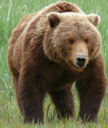

In [5]:
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(128,128)

In [6]:
bear_types = ['grizzly', 'black', 'teddy']
path = Path('bears')

In [7]:
for o in bear_types:
    print(o, len(get_image_files(path/o)))

grizzly 0
black 0
teddy 0


In [8]:
for o in bear_types:
    dest = (path/o)
    dest.mkdir(parents=True, exist_ok=True)  # ✅ make sure folder exists
    if len(get_image_files(dest)) == 0:
        print(f"Downloading {o} bears...")
        results = search_images(f'{o} bear')
        download_images(dest, urls=results)


In [9]:
for o in bear_types:
    print(o, len(get_image_files(path/o)))

grizzly 87
black 96
teddy 92


In [10]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)

(#0) []

In [11]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [12]:
dls = bears.dataloaders(path)

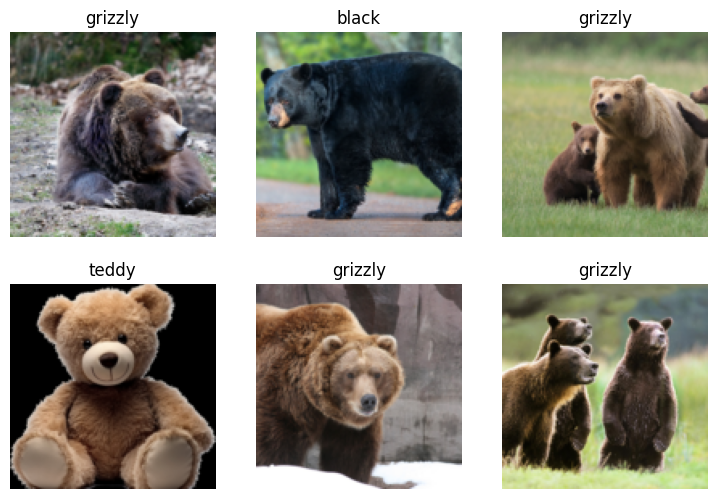

In [13]:
dls.show_batch(max_n=6)

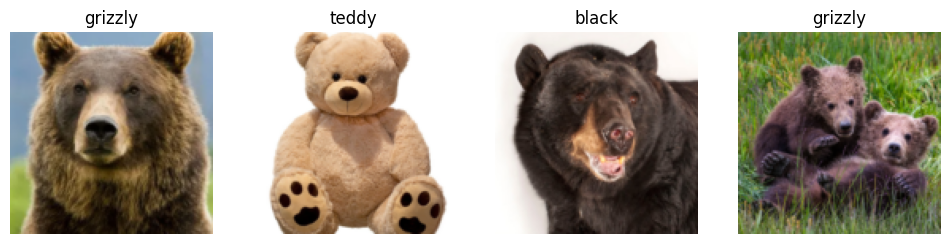

In [14]:
dls.valid.show_batch(max_n=4, nrows=1)

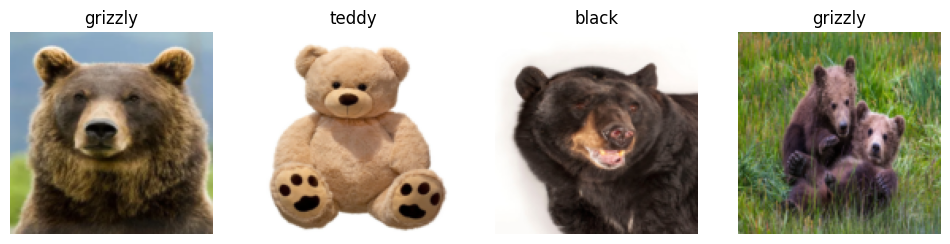

In [15]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

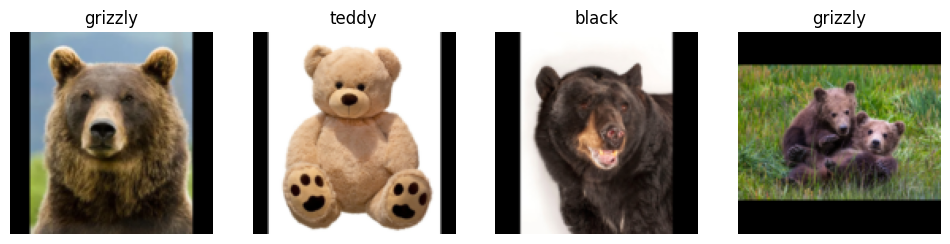

In [16]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

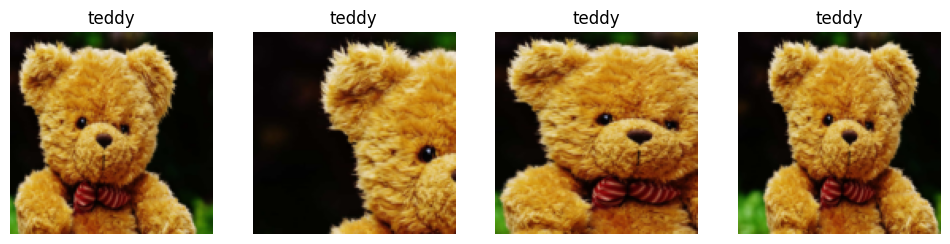

In [17]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

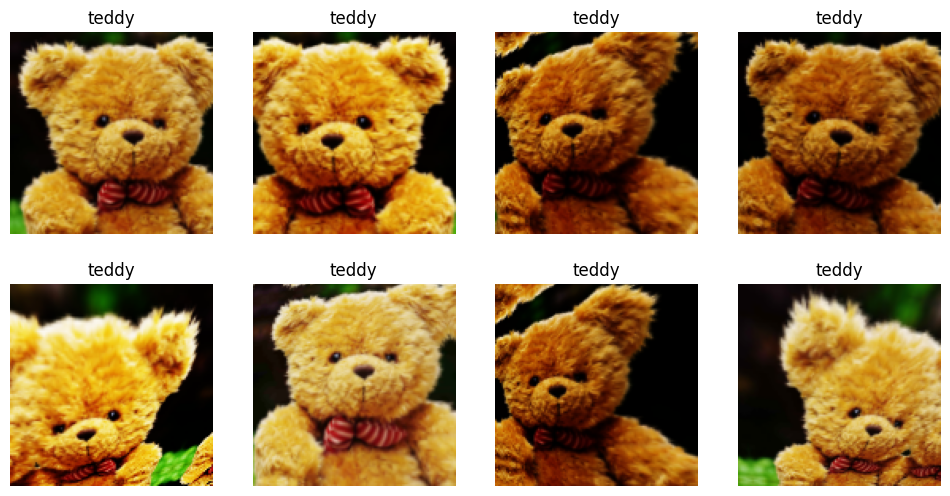

In [18]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [19]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [20]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:01<00:00, 31.8MB/s]


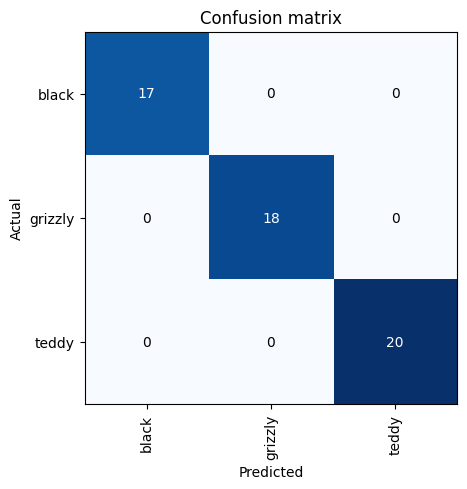

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

It shows 5 images, each annotated with:

* Predicted label (what the model thought it was)

* Actual (true) label (the correct answer)

* Loss value (how wrong the prediction was)

* Probability/confidence of the model’s prediction

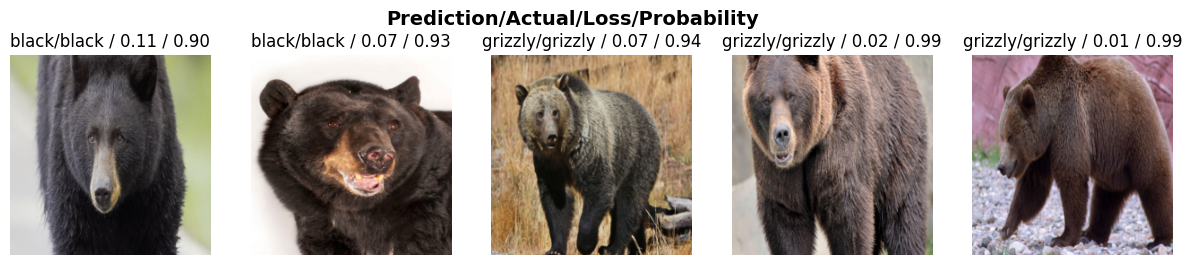

In [22]:
interp.plot_top_losses(5, nrows=1)

In [23]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

In [26]:
learn.export('/content/drive/MyDrive/Fastai Pytorch/Lessons/Lesson 2/export.pkl')

In [27]:
learn_inf = load_learner('/content/drive/MyDrive/Fastai Pytorch/Lessons/Lesson 2/export.pkl')

/usr/local/lib/python3.12/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [28]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([2.1412e-04, 9.9978e-01, 3.3638e-06]))

* learn_inf → your exported learner (usually loaded with load_learner()).

* .dls → the DataLoaders object associated with that learner.

* .vocab → the list of class labels the model was trained to recognize.

In [29]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']